Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [44]:
import numpy as np
import sklearn.model_selection
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
import os

torch.manual_seed(0)
#generates random values

In [4]:
def image_to_tensor(filepath):
    image = Image.open(filepath)
    image_tensor = torchvision.transforms.ToTensor()(image)
    image_tensor = torchvision.transforms.Grayscale(1)(image_tensor)
    image_tensor = torchvision.transforms.Normalize((0.5), (0.5))(image_tensor)
#     print(image_tensor.shape[0])
    #make it smaller
#   image_tensor = torchvision.transforms.Resize((image_tensor.shape[1]//10, image_tensor.shape[2]//10), antialias=True)(image_tensor)
    image_tensor = torchvision.transforms.Resize((180, 200), antialias=True)(image_tensor)
#     print(image_tensor.shape)
    return image_tensor
#converts image to just the tensor, makes it greyscale, resizes, normalizes it, returns it

In [5]:
# # Load the image
# image = Image.open("/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0135-0001.jpeg")

# # Convert the image to a tensor
# image_tensor = torchvision.transforms.ToTensor()(image)

# # Normalize the image tensor
# image_tensor = torchvision.transforms.Normalize((0.5), (0.5))(image_tensor)

# print(image_tensor.shape[0])

# image_tensor = torchvision.transforms.Resize((image_tensor.shape[1]//10, image_tensor.shape[2]//10), antialias=True)(image_tensor)
# # print(image)
# print(image_tensor.shape)
# plt.imshow(image_tensor.permute(1, 2, 0), cmap = "gray")

In [22]:
images_and_labels_training = []
count = 0
for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL'): #add normal ones
    for filename in filenames:
        images_and_labels_training.append((image_to_tensor(os.path.join(dirname, filename)), 0)) #0 = normal
        count += 1
        if count % 100 == 0:
            print(str(count) + " done for normal")
#walks through all the input data, appends and then distinguishes if it has pneumonia or not
count = 0            
for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'): #add normal ones
    for filename in filenames:
        #has bacterial and viral pneumonia, we want to simplify it to only consider one kind.
        if "bacteria" in filename:
            images_and_labels_training.append((image_to_tensor(os.path.join(dirname, filename)), 1)) #1 = pneumonia
            count += 1
            if count % 100 == 0:
                print(str(count) + " done for pneumonia")


100 done for normal
200 done for normal
300 done for normal
400 done for normal
500 done for normal
600 done for normal
700 done for normal
800 done for normal
900 done for normal
1000 done for normal
1100 done for normal
1200 done for normal
1300 done for normal
100 done for pneumonia
200 done for pneumonia
300 done for pneumonia
400 done for pneumonia
500 done for pneumonia
600 done for pneumonia
700 done for pneumonia
800 done for pneumonia
900 done for pneumonia
1000 done for pneumonia
1100 done for pneumonia
1200 done for pneumonia
1300 done for pneumonia
1400 done for pneumonia
1500 done for pneumonia
1600 done for pneumonia
1700 done for pneumonia
1800 done for pneumonia
1900 done for pneumonia
2000 done for pneumonia
2100 done for pneumonia
2200 done for pneumonia
2300 done for pneumonia
2400 done for pneumonia
2500 done for pneumonia


In [23]:
#testset, test and train folders
images_and_labels_testing = []
count = 0
for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL'): #add normal ones
    for filename in filenames:
        images_and_labels_testing.append((image_to_tensor(os.path.join(dirname, filename)), 0)) #0 = normal
        count += 1
        if count % 100 == 0:
            print(str(count) + " done for normal")

count = 0            
for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'): #add normal ones
    for filename in filenames:
        if "bacteria" in filename:
            images_and_labels_testing.append((image_to_tensor(os.path.join(dirname, filename)), 1)) #1 = pneumonia
            count += 1
            if count % 100 == 0:
                print(str(count) + " done for pneumonia")

100 done for normal
200 done for normal
100 done for pneumonia
200 done for pneumonia


Text(0, 0.5, 'pneumonia')

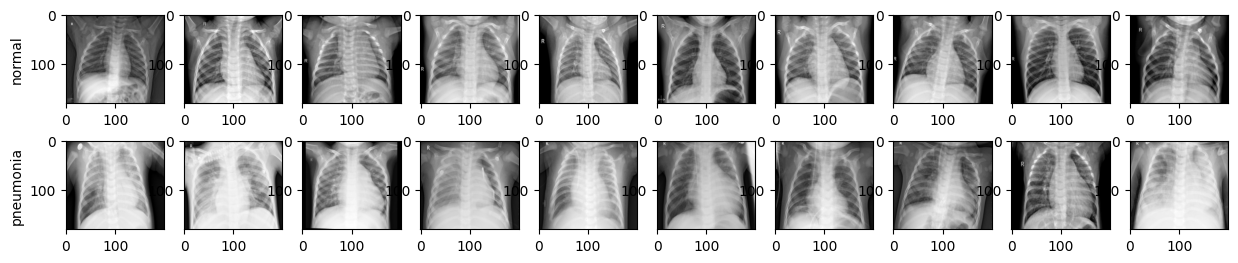

In [202]:
fig, axes = plt.subplots(2, 10, figsize = [15, 3])
i = 0
for img, value in images_and_labels_training[:10]:
    ax = axes[0, i]
    i+=1
    ax.imshow(img.permute(1, 2, 0), cmap = "gray")
    
axes[0, 0].set_ylabel("normal")

i = 0
for img, value in images_and_labels_training[-10:]:
    ax = axes[1, i]
    i+=1
    ax.imshow(img.permute(1, 2, 0), cmap = "gray")
    
axes[1, 0].set_ylabel("pneumonia")
#printed out 10 normal & 10 pneumonia x-rays

In [83]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc_model = torch.nn.Sequential(
    torch.nn.Linear(180 * 200, 500),
    torch.nn.ReLU(),
    torch.nn.Linear(500, 200),
    torch.nn.ReLU(),
    torch.nn.Linear(200, 2))

  def forward(self, x):
    x = x.view(-1,180 * 200)
    x = self.fc_model(x)
    return x
  #neural net

In [51]:
def evaluate(dataloader, net):
  total, correct = 0, 0
  net.eval() # don't update weights
  for data in dataloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    predicted_output = net(images)
    _, predicted_labels = torch.max(predicted_output,1)
    total += labels.size(0)
    correct += (predicted_labels == labels).sum().item()
  return 100 * correct/total
#evaluation & percent accuracy  

In [75]:
def run_model(images_and_labels_training, images_and_labels_testing, lr, batch_size, num_epochs):
    trainDataLoader = torch.utils.data.DataLoader(images_and_labels_training, batch_size=batch_size, shuffle=True) ##########
    testDataLoader = torch.utils.data.DataLoader(images_and_labels_testing, batch_size=batch_size, shuffle=False)

    net = Net().cuda()

    #running it

    Loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)

    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        test_loss = 0.0
        for i, data in enumerate(trainDataLoader):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()
            predicted_output = net(images)
            fit = Loss(predicted_output,labels)
            fit.backward()
            optimizer.step()
            train_loss += fit.item()
        for i, data in enumerate(testDataLoader):
            with torch.no_grad():
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                predicted_output = net(images)
                fit = Loss(predicted_output,labels)
                test_loss += fit.item()
        train_loss = train_loss/len(trainDataLoader)
        test_loss = test_loss/len(testDataLoader)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        train_accuracy_history.append(evaluate(trainDataLoader, net))
        test_accuracy_history.append(evaluate(testDataLoader, net))
        print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))
        print('Train acc = %0.2f, test acc = %0.2f' % (train_accuracy_history[-1], test_accuracy_history[-1]))
    #finding % accuracy each epoch
    fig, axes = plt.subplots(2, 1)
    ax = axes[0]
    ax.plot(np.arange(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
    ax.plot(np.arange(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.grid(True)
    ax.legend()
    ax = axes[1]
    ax.plot(np.arange(num_epochs),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
    ax.plot(np.arange(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
    ax.set_xlabel('epoch')
    ax.set_ylabel('% accuracy')
    ax.grid(True)
    ax.legend()
    #plot loss function for train and test
    print("Estimated test accuracy (average of exact accuracies of last 5 epochs): " + str(round(sum(test_accuracy_history[-5:])/5, 2)) + "%")

Epoch 0, Train loss 0.8226943841735131, Test loss 0.39821761697530744
Train acc = 91.27, test acc = 87.18
Epoch 1, Train loss 0.25733114721268907, Test loss 0.5728073417131478
Train acc = 95.53, test acc = 81.30
Epoch 2, Train loss 0.15269353789997034, Test loss 1.3474243518037838
Train acc = 95.38, test acc = 68.70
Epoch 3, Train loss 0.12113298477955194, Test loss 0.42451935439312366
Train acc = 95.04, test acc = 85.08
Epoch 4, Train loss 0.1166807151051269, Test loss 1.187416661060585
Train acc = 96.90, test acc = 73.53
Epoch 5, Train loss 0.09929015883172415, Test loss 2.0929656463534836
Train acc = 96.62, test acc = 68.91
Epoch 6, Train loss 0.08823780998818996, Test loss 1.329224558221055
Train acc = 97.83, test acc = 70.59
Epoch 7, Train loss 0.07959449869818208, Test loss 0.8988674402688048
Train acc = 97.68, test acc = 75.84
Epoch 8, Train loss 0.07497368363975278, Test loss 0.9969592936885117
Train acc = 98.37, test acc = 76.05
Epoch 9, Train loss 0.05835381345072961, Test lo

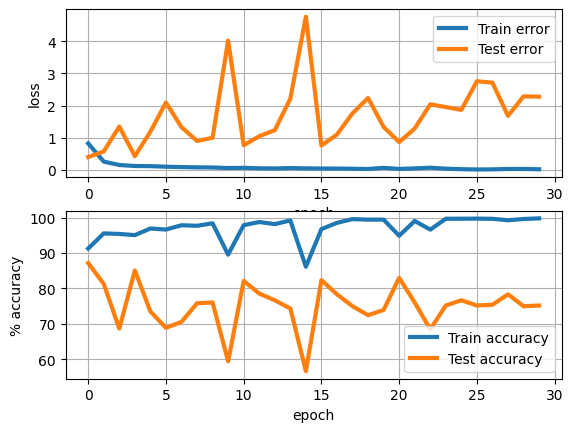

In [76]:
#default values:
run_model(images_and_labels_training, images_and_labels_testing, 0.1, 16, 30)

### It's possible that the learning rate is too high, since the training data gets very overfit.

Epoch 0, Train loss 0.3118807079332057, Test loss 0.2837233163105945
Train acc = 93.59, test acc = 88.66
Epoch 1, Train loss 0.13861140425409352, Test loss 0.553765163772429
Train acc = 96.33, test acc = 79.20
Epoch 2, Train loss 0.1091832348438026, Test loss 0.7790528603286172
Train acc = 96.64, test acc = 75.21
Epoch 3, Train loss 0.0996809701795097, Test loss 0.9551592025246161
Train acc = 97.49, test acc = 73.95
Epoch 4, Train loss 0.09121289321948767, Test loss 0.8371803969455262
Train acc = 97.68, test acc = 76.05
Epoch 5, Train loss 0.08358227300615442, Test loss 0.6242732969345525
Train acc = 96.54, test acc = 79.62
Epoch 6, Train loss 0.0726758479963303, Test loss 0.6220295762177557
Train acc = 96.64, test acc = 81.51
Epoch 7, Train loss 0.06367973150966366, Test loss 1.4428636150473417
Train acc = 97.03, test acc = 69.33
Epoch 8, Train loss 0.05815018512778107, Test loss 1.203198451885449
Train acc = 98.01, test acc = 73.32
Epoch 9, Train loss 0.0542379337891384, Test loss 0.

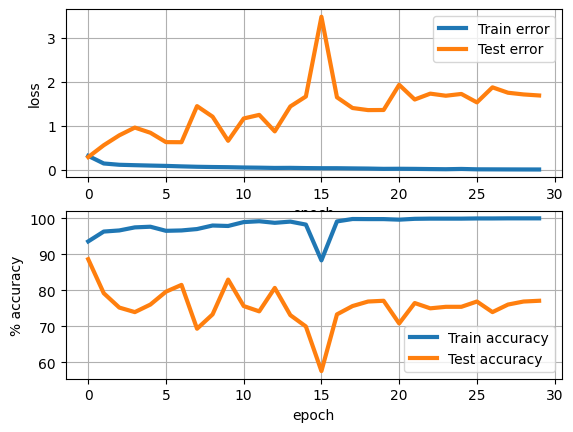

In [77]:
run_model(images_and_labels_training, images_and_labels_testing, 0.01, 16, 30)

### We've resolved this issue, but why is the test loss/accuracy not improving (even getting worse)? Looking at the Kaggle discussion posts about this dataset, it seems like the "test" data had labeling issues which stopped users from getting an accuracy above 75% (exactly what we see here). So let's create our own train and test sets by using only the data from the given "train" set to generate both.

In [45]:
imglabel_trainingv2, imglabel_testingv2 = sklearn.model_selection.train_test_split(images_and_labels_training, test_size = 0.2)

Epoch 0, Train loss 0.34762935206946943, Test loss 0.14710230384098025
Train acc = 93.90, test acc = 94.97
Epoch 1, Train loss 0.14340612239962847, Test loss 0.2078542695665846
Train acc = 91.09, test acc = 92.52
Epoch 2, Train loss 0.117355507692879, Test loss 0.19078258362275605
Train acc = 92.44, test acc = 93.03
Epoch 3, Train loss 0.10009697648893427, Test loss 0.16462426483916232
Train acc = 96.22, test acc = 93.68
Epoch 4, Train loss 0.09159472988097515, Test loss 0.3022008331644596
Train acc = 92.67, test acc = 89.81
Epoch 5, Train loss 0.07764766576427477, Test loss 0.18020774583731378
Train acc = 96.19, test acc = 93.81
Epoch 6, Train loss 0.07754133878630999, Test loss 0.1159306075946637
Train acc = 98.29, test acc = 96.00
Epoch 7, Train loss 0.06070695887199728, Test loss 0.13648130323462265
Train acc = 97.87, test acc = 95.23
Epoch 8, Train loss 0.06184640842413088, Test loss 0.11451885759193754
Train acc = 98.80, test acc = 96.26
Epoch 9, Train loss 0.05516349576046383, T

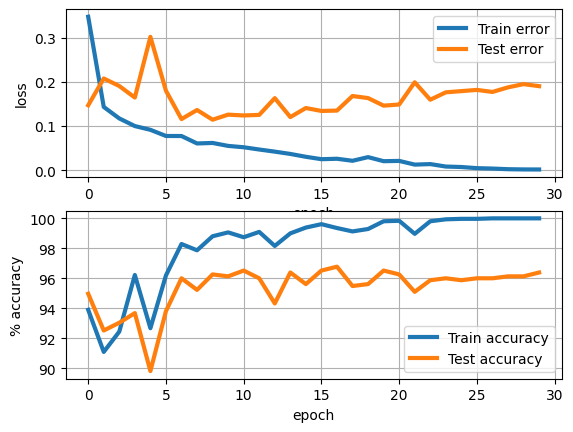

In [78]:
run_model(imglabel_trainingv2, imglabel_testingv2, 0.01, 16, 30)

### The accuracy is very good - 96% - but it still doesn't resemble the typical loss curves. Maybe reduce the learning rate?

Epoch 0, Train loss 0.6086181816981011, Test loss 0.5446843705615219
Train acc = 81.33, test acc = 82.06
Epoch 1, Train loss 0.4943069450019561, Test loss 0.44645235672289013
Train acc = 89.11, test acc = 88.26
Epoch 2, Train loss 0.40428863358251826, Test loss 0.3722310516299034
Train acc = 91.89, test acc = 90.32
Epoch 3, Train loss 0.33737275933789224, Test loss 0.31727797735710533
Train acc = 92.89, test acc = 91.10
Epoch 4, Train loss 0.28787157715288636, Test loss 0.27549133647461327
Train acc = 93.35, test acc = 91.87
Epoch 5, Train loss 0.2510242324284057, Test loss 0.24464832337535158
Train acc = 93.73, test acc = 92.90
Epoch 6, Train loss 0.22413287127448112, Test loss 0.22170102276972362
Train acc = 94.22, test acc = 92.65
Epoch 7, Train loss 0.20342602584626257, Test loss 0.20313902716247403
Train acc = 94.54, test acc = 92.90
Epoch 8, Train loss 0.18703138371257438, Test loss 0.19496422245794412
Train acc = 94.64, test acc = 92.77
Epoch 9, Train loss 0.17447286786645957, T

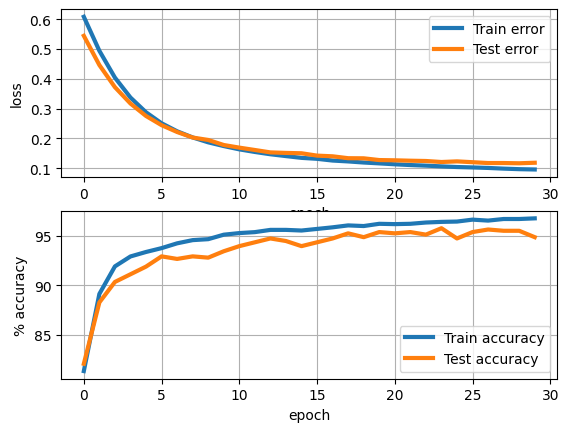

In [87]:
run_model(imglabel_trainingv2, imglabel_testingv2, 0.0003, 16, 30)


### Wow this is so much better! Since the loss was so small (<1, when the mnist fashion dataset produced loss values in the hundreds), using a typical lr of 0.1 evidently was too drastic. Now we have a test accuracy of just over 95%, which feels like a success!

In [182]:
# class Net(torch.nn.Module):
#   def __init__(self):
#     super(Net, self).__init__()
#     self.model_layer1 = torch.nn.Sequential(
#         #start size: 180x200
#         torch.nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 80),
#         torch.nn.ReLU(), #it seems like tanh is more commonly used, but relu is less computationally heavy?
#         torch.nn.MaxPool2d(kernel_size = 4, stride = 4))
    
#     self.model_layer2 = torch.nn.Sequential(
#         #start size: 180x200
#         torch.nn.Conv2d(in_channels = 6, out_channels = 20, kernel_size = 5),
#         torch.nn.ReLU(),
#         torch.nn.MaxPool2d(kernel_size = 4, stride = 4))
    
#     self.lin1 = torch.nn.Linear(600, 120)
#     self.lin2 = torch.nn.Linear(120, 84)
#     self.lin3 = torch.nn.Linear(84, 2)
#     self.relu = torch.nn.ReLU()
    
#   def forward(self, x):
#     curr = self.model_layer1(x)
#     curr = self.model_layer2(curr)
#     curr = curr.reshape(curr.size(0), -1) #flatten 16x(5x5) to 400
#     #apply the next parts
#     curr = self.lin1(curr)
#     curr = self.relu(curr)
#     curr = self.lin2(curr)
#     curr = self.relu(curr)
#     curr = self.lin3(curr)
#     return curr

tried to make something resembling LeNet5, but wasn't successful.